In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Maxwell's equations on a periodic 1D grid of $[0,L]$

Consider the homogeneous 1D Maxwell equations on our periodic domain

\begin{equation}
\left\{
\begin{split}
\frac{\partial E}{\partial t} + \frac{\partial B}{\partial x} &= 0, \\
\frac{\partial B}{\partial t} + \frac{\partial E}{\partial x} &= 0,
\end{split}
\right.
\end{equation}

with initial conditions $E(t=0,x) = E_0(x)$ and $B(t=0,x) = B_0(x)$.

## Exact solution

By summing or subtracting Amperè's and Faraday's laws, one obtains two decoupled scalar advection equations

\begin{equation}
\left(\frac{\partial}{\partial t} + \frac{\partial}{\partial x}\right) v_1 = 0,
\qquad
\left(\frac{\partial}{\partial t} - \frac{\partial}{\partial x}\right) v_2 = 0,
\end{equation}

where we have introduced the fields

\begin{equation}
\begin{matrix}
v_1 := E + B \\
v_2 := E - B
\end{matrix}
\qquad
\text{so that}
\qquad
\begin{matrix}
E = \dfrac{v_1 + v_2}{2} \\
B = \dfrac{v_1 - v_2}{2}
\end{matrix}
\end{equation}

The exact solution to these equations are traveling waves with propagation velocity $\lambda_{1} = 1$ and $\lambda_{2} = -1$, respectively:

\begin{equation}
v_1(t,x) = v_1(0,x-t),
\qquad
v_2(t,x) = v_2(0,x+t).
\end{equation}

Clearly, $v_{1,2} = E \pm B$ are the __eigenvectors__ of the 1D Maxwell equations, and $\lambda_{1,2} = \pm 1$ are the corresponding __eigenvalues__.

It is now possible to write the exact solution of the 1D Maxwell equations by converting the initial conditions $E(0,x)$ and $B(0,x)$ into the eigenvectors $v_{1,2}(0,x)$, then solving for $v_{1,2}(t,x)$, and finally converting back to $E(t,x)$ and $B(t,x)$. These three steps can be combined to give

\begin{align}
E(t,x) &= \frac{1}{2}\big[ E_0(x-t) + E_0(x+t) \big]
        + \frac{1}{2}\big[ B_0(x-t) - B_0(x+t) \big], \\
B(t,x) &= \frac{1}{2}\big[ B_0(x-t) + B_0(x+t) \big]
        + \frac{1}{2}\big[ E_0(x-t) - E_0(x+t) \big].
\end{align}

In [2]:
def exact_solution(E0, B0):
    E = lambda t, x : 0.5 * (E0(x - t) + E0(x + t) + B0(x - t) - B0(x + t))
    B = lambda t, x : 0.5 * (B0(x - t) + B0(x + t) + E0(x - t) - E0(x + t))
    return E, B

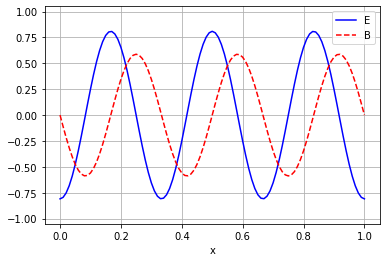

In [3]:
# Domain
x = np.linspace(0, 1, 101)

# Number of periods in domain
a = 3

# Callable functions E(t,x) and B(t,x)
E, B = exact_solution(
    E0 = lambda x: np.cos((a*2*np.pi) * x),
    B0 = lambda x: 0.0*np.cos((a*2*np.pi) * x)
)

def plot_exact_solution(t):
    fig = plt.figure(10)
    ax = fig.axes[0] if len(fig.axes) == 1 else fig.add_subplot(1, 1, 1)
    while len(ax.lines) > 0:
        ax.lines.pop()
    ax.plot(x, E(t, x), 'b', label='E')
    ax.plot(x, B(t, x), 'r--', label='B')
    ax.legend(loc='upper right')
    ax.set_ylim([-1.05, 1.05])
    ax.set_xlabel('x')
    ax.grid(True)
    fig.canvas.draw()

plot_exact_solution(0.2)

## Some useful functions

In [4]:
def step_E(dt, dx, E, B):
    E += (dt / dx) * (np.roll(B, +1) - B)

def step_B(dt, dx, E, B):
    B += (dt / dx) * (E - np.roll(E, -1))

In [5]:
def exact_solution(xmin, xmax, a):
    """
    Manufacture a sinusoidal exact solution for the fields E(t,x) and B(t,x)
    on a periodic domain [xmin, xmax].

    Parameters
    ----------
    xmin : float
        Left boundary of 1D domain.

    xmax : float
        Right boundary of 1D domain.

    a : int
        Number of wavelengths in domain.

    Results
    -------
    f : callable
        Exact solution f(t,x) for fields E and B.

    """
    k = a * (2 * np.pi) / (xmax - xmin)
    f = lambda t, x: np.sin(k * (x - t))

    return f

In [6]:
def energy(dx, E, B):
    """ Compute total energy in domain given the fields E and B.
    """
    return 0.5 * dx * (np.dot(E, E) + np.dot(B, B))

# Standard method

In [7]:
def standard_scheme(L, a, N, Cp, T, plot_interval):

    #--------------------------------------------------------
    # SETUP
    #--------------------------------------------------------

    # Exact solution
    f = exact_solution(0, L, a)

    # constructing the grid
    dx     = L / N
    x_prim = dx * np.arange(N)

    # Time step size
    dt = Cp * dx
    
    # number of time steps
    nsteps = int(round(float(T)/dt))

    # Initial time and initial conditions
    t = 0
    E = f(t, x_prim)  # solution array (E_{i})_i
    B = f(t, x_prim)  # solution array (B_{i})_i

    # Compute energy at t=0
    ts = [t]
    energies = [energy(dx, E, B)]


    #--------------------------------------------------------
    # SOLUTION
    #--------------------------------------------------------

    # Time loop
    for i in range(nsteps):

        # Advance both E and B by one time-step
        step_B(dt, dx, E, B)  # Bring B from t - ∆t/2 to t + ∆t/2
        step_E(dt, dx, E, B)  # Bring E from t to t + ∆t
        t += dt

        #... Diagnostics
        if i % plot_interval == 0 or i == nsteps-1:

            # Compute energy
            ts.append(t)
            energies.append(energy(dx, E, B))
        #...
    
    plt.plot(ts, energies, '-b', label='Energy')
    plt.legend();

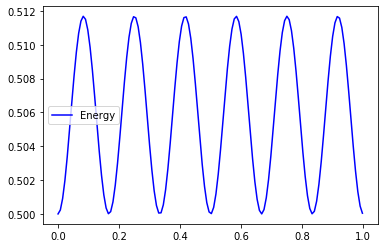

In [8]:
standard_scheme(L=1.0, a=3, N=100, Cp=0.75, T=1., plot_interval=1)

**What happens when you increase Cp?**

# Yee method

## Staggered grid

Consider the periodic 1D interval $[0, L]$. The primal grid consists of the nodes of a uniform grid of $N$ cells $x_j = j L~/N$ for $0\le j < N$, and the dual grid consists of the midpoints of the cells $x_{j+1/2} = \left(j+\frac{1}{2}\right) L~/N$ for $0\le j < N$.

![title](images/staggered_grid.png)

In [9]:
def staggered_grid(xmin, xmax, N):
    """
    Create a uniform staggered grid on a 1D periodic domain.

    Parameters
    ----------
    xmin : float
        Left boundary of 1D domain.

    xmax : float
        Right boundary of 1D domain.

    N : int
        Number of cells in domain.

    Results
    -------
    dx : float
        Cell size.

    x_prim : 1D numpy.ndarray
        Coordinates of vertices of primal grid.

    x_dual : 1D numpy.ndarray
        Coordinates of vertices of dual grid.
    """

    dx     = (xmax - xmin) / N
    x_prim = dx * np.arange(N)
    x_dual = x_prim + dx / 2

    return dx, x_prim, x_dual

## Yee's scheme

Given a time-step size $\Delta t$, a staggered grid is also created in time:

1. The primal grid has values $t_n = n\Delta t$ for $n\in\mathbb{N}$;
2. The dual grid has values $t_{n+1/2} = \left(n +\frac{1}{2}\right)\Delta t$ for $n\in\mathbb{N}$.

Moreover:

- The field $E$ is described by its point values on the ___primal___ space-time grid $(t_n, x_j)$;
- The field $B$ is described by its point values on the ___dual___ space-time grid $(t_{n+1/2}, x_{j+1/2})$;
- The time and spatial derivatives of $E$ and $B$ are approximated by 2nd-ordered centered finite difference formulas.

We obtain therefore the following update formulas, to be applied consecutively:

\begin{align}
%
\color{orange}{B^{n+1/2}_{j+1/2}} &= B^{n-1/2}_{j+1/2} +
    \frac{\Delta t}{\Delta x}\left(E^{n}_{j} - E^{n}_{j+1}\right),
    \qquad {0\le j < N},\\
%
\color{cyan}{E^{n+1}_{j}} &= E^n_{j} + \frac{\Delta t}{\Delta x}
    \left(\color{orange}{B^{n+1/2}_{j-1/2}} - \color{orange}{B^{n+1/2}_{j+1/2}} \right),
    \qquad {0\le j < N}.
%
\end{align}


### Startup and shutdown

Notice that at time $n=0$ one needs to compute the values $\left\{B^{-1/2}_{j+1/2}\right\}_j$ from the initial condition $\left\{B^{0}_{j+1/2}\right\}_j$ in order to start the scheme:

\begin{equation}
  B^{-1/2}_{j+1/2} = B^0_{j+1/2} - \frac{\Delta t}{2\Delta x}
  \left(E^{0}_{j} - E^{0}_{j+1}\right),
  \qquad {0\le j < N}.
\end{equation}

Similarly, at the last time step $M$ one needs to compute the final solution $\left\{B^{M}_{j+1/2}\right\}_j$ from the previous values $\left\{B^{M-1/2}_{j+1/2}\right\}_j$:

\begin{equation}
  B^{M}_{j+1/2} = B^{M-1/2}_{j+1/2} + \frac{\Delta t}{2\Delta x}
  \left(E^{M}_{j} - E^{M}_{j+1}\right),
  \qquad {0\le j < N}.
\end{equation}

In general, the operation of pushing the discrete $B$ field forward (and then backward) in time is required whenever the solution needs to be visualized.


### Vector formulation

If we define the (circulant) differentiation matrix $D \in \mathbb{R}^{N \times N}$ as

\begin{equation}
  D = \frac{\Delta t}{\Delta x}~
  \begin{pmatrix}
     1 &  0 & \dots  & \dots  & -1 \\
    -1 &  1 &        &        &  0 \\
     0 & -1 &  1     &        &    \\
       &    & \ddots & \ddots &    \\
     0 &    & \ddots &   -1   &  1 \\
  \end{pmatrix}
\end{equation}

we can write the Yee scheme as

\begin{align}
%
\color{orange}{B^{n+1/2}} &= B^{n-1/2} + D^T~E^{n},\\
%
\color{cyan}{E^{n+1}} &= E^n - D~\color{orange}{B^{n+1/2}}.
%
\end{align}

### Energy conservation

The electromagnetic energy in the continuous system at time $t$ is

\begin{equation}
  W(t) = \frac{1}{2} \int_0^L \left[ E^2(t) + B^2(t) \right] dx,
\end{equation}

which is constant in time thanks to the periodic boundary conditions. The Yee scheme cannot conserve the continuous energy $W$, but it exactly preserves a discrete energy $\mathcal{W} \approx W$ which will be defined as follows. Let's define the $L^2$ inner product

\begin{equation}
\langle u, v \rangle_h = \Delta x \sum_{j=0}^{N-1} u_j v_j,
\end{equation}

and notice that the dual operator of $D$ with respect to such inner product is $D^{T}$, that is

\begin{equation}
\langle D u, v \rangle_h = \langle u, D^{T} v \rangle_h.
\end{equation}

Let's consider the Yee update equations in vector form. If we take the inner product of the first equation with $\left(B^{n+1/2}+B^{n-1/2}\right)$, and the inner product of the second equation with $\left(E^{n+1}+E^{n}\right)$, after rearranging the terms we obtain

\begin{align}
\langle B^{n+1/2}, B^{n+1/2} \rangle &= 
\langle B^{n-1/2}, B^{n-1/2} \rangle +
\langle B^{n+1/2}, D^{T}E^{n} \rangle +
\langle B^{n-1/2}, D^{T}E^{n} \rangle
\\
\langle E^{n+1}, E^{n+1} \rangle +
\langle D~B^{n+1/2}, E^{n+1}\rangle &= 
\langle E^{n}, E^{n} \rangle -
\langle D~B^{n+1/2}, E^{n} \rangle
\end{align}

Summing these two equations side-by-side, and noticing that $\langle D~B^{n+1/2}, E^{n}\rangle = \langle B^{n+1/2}, D^{T}E^{n} \rangle$, we obtain

\begin{equation}
\big\| E^{n+1} \big\| +
\big\| B^{n+1/2} \big\| +
\left\langle D~B^{n+1/2}, E^{n+1}\right\rangle
\,=\,
\big\| E^{n} \big\| +
\big\| B^{n-1/2} \big\| +
\left\langle D~B^{n-1/2}, E^{n} \right\rangle
\end{equation}

which can be written as an _exact conservation_ $\mathcal{W}^{n+1} = \mathcal{W}^{n}$ for the discrete energy

\begin{equation}
\boxed{
\mathcal{W}^{n} :=
\frac{1}{2} \big\| E^{n} \big\|^2 +
\frac{1}{2} \big\| B^{n-1/2} \big\|^2 +
\frac{1}{2} \left\langle D~B^{n-1/2}, E^{n} \right\rangle
}
\end{equation}

Hence, the discrete energy $\mathcal{W}^{n}$ as defined above is exactly conserved by the Yee scheme. An equivalent formula that uses the magnetic field at two successive time steps is

\begin{equation}
\mathcal{W}^{n} :=
\frac{1}{2} \big\langle E^{n}, E^{n} \big\rangle +
\frac{1}{2} \big\langle B^{n-1/2}, B^{n+1/2} \big\rangle
\end{equation}

Using the formulas for the startup and shutdown of the Yee scheme, this can be rewritten as

\begin{equation}
\mathcal{W}^{n} :=
\frac{1}{2} \big\langle E^{n}, E^{n} \big\rangle +
\frac{1}{2} \big\langle B^{n} - \frac{1}{2}D^T E^{n},
B^{n} + \frac{1}{2} D^T E^{n}\big\rangle.
\end{equation}

Any of the three equivalent formulas can be used in the code as an energy diagnostic.

In [10]:
def yee_scheme(L, a, N, Cp, T, plot_interval):
        
    #--------------------------------------------------------
    # SETUP
    #--------------------------------------------------------

    # Exact solution
    f = exact_solution(0, L, a)

    # Staggered grid (E is on primal grid, B is on dual grid)
    dx, x_prim, x_dual = staggered_grid(0, L, N)

    # Time step size
    dt = Cp * dx
    
    # number of time steps
    nsteps = int(round(float(T)/dt))

    # Initial time and initial conditions
    t = 0
    E = f(t, x_prim)  # solution array (E_{i})_i
    B = f(t, x_dual)  # solution array (B_{i+1/2})_i

    # Compute energy at t=0
    ts = [t]
    energies = [energy(dx, E, B)]


    #--------------------------------------------------------
    # SOLUTION
    #--------------------------------------------------------

    # Push B backward in time by half time-step
    step_B(-dt/2, dx, E, B)

    # Time loop
    for i in range(nsteps):

        # Advance both E and B by one time-step
        step_B(dt, dx, E, B)  # Bring B from t - ∆t/2 to t + ∆t/2
        step_E(dt, dx, E, B)  # Bring E from t to t + ∆t
        t += dt

        #... Diagnostics
        if i % plot_interval == 0 or i == nsteps-1:

            # Bring B to same time instant as E
            step_B(dt/2, dx, E, B)

            # Compute energy
            ts.append(t)
            energies.append(energy(dx, E, B))

            # Push B back by half time-step
            step_B(-dt/2, dx, E, B)
        #...

    # Bring B to same time instant as E
    step_B(dt/2, dx, E, B)
    
    plt.plot(ts, energies, '-b', label='Energy')
    plt.legend();

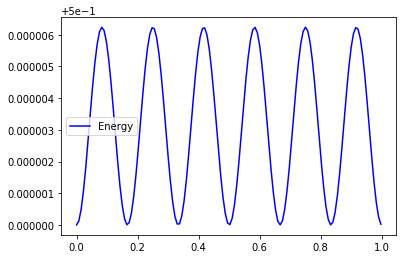

In [11]:
yee_scheme(L=1.0, a=3, N=100, Cp=0.75, T=1., plot_interval=1)

**What happens when you increase Cp?**